In [60]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import autocorrelation_plot
from IPython.display import display, HTML as HTML_display

import scipy.stats as stats

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GRU, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch, Hyperband, BayesianOptimization

In [61]:
df = pd.read_excel('../../../data/tb_stock.xlsx')
df = df.iloc[-3000:, :][['sc_date', 'sc_coin']]
# 날짜 데이터를 유지
df['sc_date'] = pd.to_datetime(df['sc_date'])

# 데이터 전처리
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['sc_coin'].values.reshape(-1, 1))
df['bit_Close_Scaled'] = scaled_data

In [3]:
# 데이터셋을 훈련과 테스트로 분리
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

# 시퀀스 데이터 생성 함수
def create_sequences_with_dates(data, dates, seq_length):
    X, y, y_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
        y_dates.append(dates[i + seq_length])
    return np.array(X), np.array(y), np.array(y_dates)

# 50일치 데이터를 사용하여 다음 날을 예측
seq_length = 50

In [4]:
data = df['bit_Close_Scaled'].values
dates = df['sc_date'].values
X, y, y_dates = create_sequences_with_dates(data, dates, seq_length)

X_train, X_test, y_train, y_test, y_train_dates, y_test_dates = train_test_split(X, y, y_dates, test_size=0.2, random_state=42, shuffle=False)

print(f'X_train shqpe : {X_train.shape}, y_train shape : {y_train.shape}')
print(f'X_test shqpe : {X_train.shape}, y_test shape : {y_train.shape}')

X_train shqpe : (2360, 50), y_train shape : (2360,)
X_test shqpe : (2360, 50), y_test shape : (2360,)


In [5]:
# GRU 모델 정의
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 208ms/step - loss: 0.0131 - val_loss: 7.7370e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0016 - val_loss: 6.2225e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0012 - val_loss: 5.6808e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 9.7601e-04 - val_loss: 7.9924e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012 - val_loss: 4.8670e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0011 - val_loss: 4.7600e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 9.4728e-04 - val_loss: 4.9705e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 9.4621e-04 - val_loss: 4.6016e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 8.9801e-04 - val_loss: 0.0011
Epoch 12/50
7

19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 299ms/step


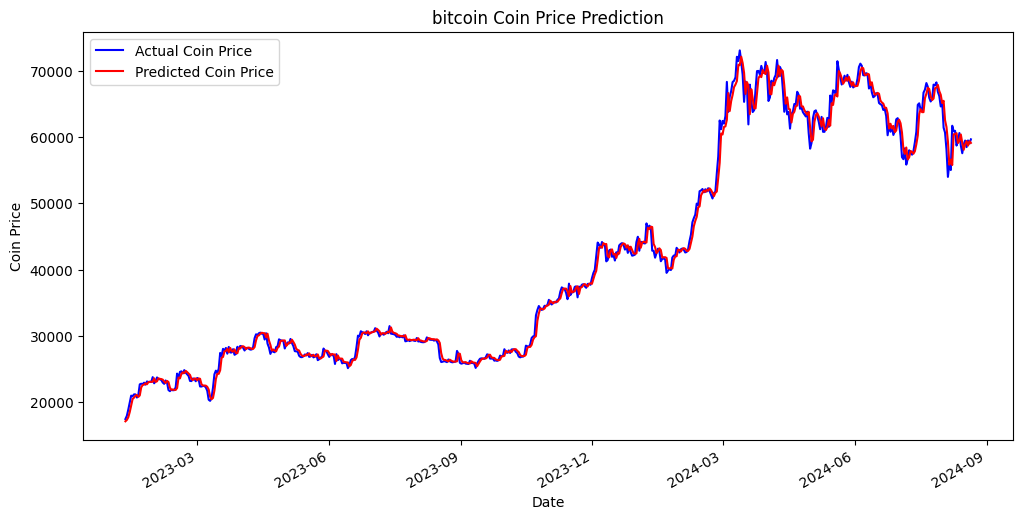

In [6]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test_scaled, color='blue', label='Actual Coin Price')
plt.plot(y_test_dates, predicted_stock_price, color='red', label='Predicted Coin Price')

# 한 달에 하나씩 날짜 표시 (간격을 월별로 설정)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('bitcoin Coin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Coin Price')
plt.legend()
plt.show()

In [7]:
# 모델 구축 함수
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation='relu', kernel_regularizer=l2(0.02)))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1))  # 최종 출력 레이어

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='mse')
    return model

In [8]:
# 짧은 경로 설정
logging_dir = os.path.abspath('C:/my_dir')

if os.path.exists(logging_dir):
    shutil.rmtree(logging_dir)

os.makedirs(logging_dir)

In [9]:
# Hyperparameter Tuner 설정
tuner = RandomSearch(
    build_model,
    objective           ='val_loss',
    max_trials          =10,              # 몇번 시도할건지 설정
    executions_per_trial=2,               # 각 조합을 더 많이 시도해 평균화
    directory           =logging_dir,
    project_name        ='gru_tuning'
)

In [10]:
# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 교차검증 실행 및 최적 모델 탐색
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_fold = None
best_model = None
best_loss = float('inf')
best_hyperparameters = None

fold_no = 1

In [11]:
for train_index, test_index in kf.split(X):
    print(f'Training on fold {fold_no}...')
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 모델 학습
    tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])
    
    # 현재 폴드의 최적의 모델과 하이퍼파라미터 선택
    fold_best_model = tuner.get_best_models(num_models=1)[0]
    fold_best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    # 현재 폴드의 모델 평가
    fold_loss = fold_best_model.evaluate(X_test, y_test)
    print(f'Fold {fold_no} - Loss: {fold_loss}')
    
    # 현재 폴드가 가장 좋은 성능을 보였다면, 해당 모델과 하이퍼파라미터 저장
    if fold_loss < best_loss:
        best_loss = fold_loss
        best_fold = fold_no
        best_model = fold_best_model
        best_hyperparameters = fold_best_hyperparameters
    
    fold_no += 1


Trial 10 Complete [00h 01m 19s]
val_loss: 1.6180710196495056

Best val_loss So Far: 0.006315740291029215
Total elapsed time: 00h 09m 03s


c:\Anaconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0052  
Fold 1 - Loss: 0.006134450435638428
Training on fold 2...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051  
Fold 2 - Loss: 0.006081753876060247
Training on fold 3...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050  
Fold 3 - Loss: 0.00591153372079134
Training on fold 4...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054  
Fold 4 - Loss: 0.006592511665076017
Training on fold 5...
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053  
Fold 5 - Loss: 0.0063405646942555904


In [12]:
# 최적의 모델로 예측 수행
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 384)            │        19,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       147,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,809 (655.50 KB)

 Trainable params: 167,809 (655.50 KB)

 Non-trainable params: 0 (0.00 B)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


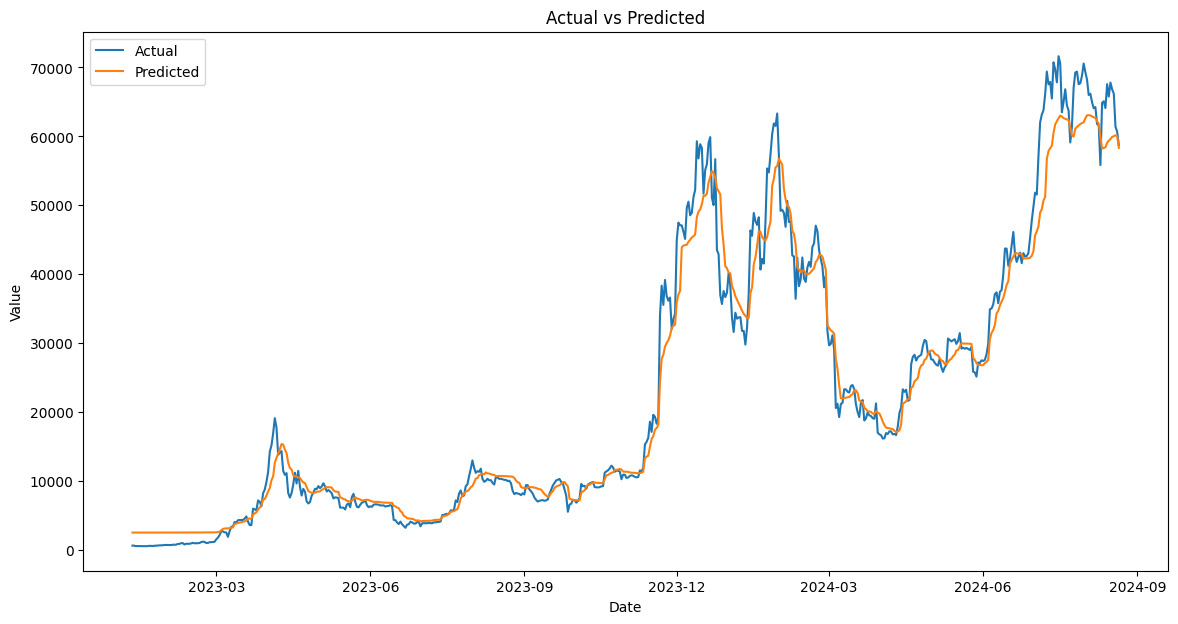

In [13]:
# 최적의 모델로 예측 수행
y_pred = best_model.predict(X_test)

# 예측 결과를 스케일링 원복
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측 결과와 실제 값을 비교하는 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(y_test_dates, y_test_scaled, label='Actual')
plt.plot(y_test_dates, y_pred, label='Predicted')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [14]:
# 학습 데이터에 대한 예측
y_train_pred = best_model.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))
y_train_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))

# MSE 계산
train_mse = mean_squared_error(y_train_scaled, y_train_pred)
test_mse = mean_squared_error(y_test_scaled, y_pred)

# R-squared 계산
train_r2 = r2_score(y_train_scaled, y_train_pred)
test_r2 = r2_score(y_test_scaled, y_pred)

# 결과 출력
print(f'Train MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Train R-squared: {train_r2:.4f}')
print(f'Test R-squared: {test_r2:.4f}')

# 과대적합/과소적합 여부 확인
if train_mse < test_mse and (train_mse / test_mse) < 0.8:
    print("과대적합이 발생할 가능성이 있습니다.")
elif train_mse > test_mse and (test_mse / train_mse) < 0.8:
    print("과소적합이 발생할 가능성이 있습니다.")
else:
    print("모델이 적절하게 학습된 것으로 보입니다.")

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train MSE: 11149654.2602
Test MSE: 11994129.7994
Train R-squared: 0.9698
Test R-squared: 0.9708
모델이 적절하게 학습된 것으로 보입니다.


In [31]:
def predict_future_prices(gru_model, recent_60_days_data, scaler, future_days=30):
    """
    60일간의 데이터를 기반으로 1개월 동안의 주가를 예측하는 함수.
    
    Parameters:
    - gru_model: 이미 학습된 모델 (GRU가 아닐 경우 Dense 레이어 기반)
    - recent_60_days_data: 최근 60일간의 스케일링된 주가 데이터 (numpy array)
    - scaler: MinMaxScaler 객체
    - future_days: 예측할 미래 일수 (기본값: 30일)
    
    Returns:
    - predictions_scaled_back: 예측된 주가를 원래 스케일로 복원한 값 (numpy array)
    - future_dates: 예측된 주가에 해당하는 미래 날짜 (pandas DatetimeIndex)
    """
    
    predictions = []
    latest_sequence = recent_60_days_data[-50:]  # 최근 50일간의 데이터를 사용 (모델에 맞게 조정)

    # 시퀀스 데이터를 사용하여 미래 예측 반복
    for _ in range(future_days):
        # 현재 시퀀스를 모델에 입력하여 예측 수행 (reshape to match the model's expected input)
        latest_sequence_reshaped = latest_sequence.reshape(1, -1)  # (1, 50)으로 reshape
        prediction = gru_model.predict(latest_sequence_reshaped)
        
        # 예측 결과를 저장하고, 시퀀스를 업데이트하여 다음 예측 준비
        predictions.append(prediction[0, 0])
        latest_sequence = np.append(latest_sequence[1:], prediction)
    
    # 예측된 값을 원래 스케일로 변환
    predictions_scaled_back = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    
    # 예측 날짜 생성 (최근 60일 데이터의 마지막 날짜로부터 미래 30일 생성)
    last_date = pd.to_datetime(df['sc_date'].values[-1])
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=future_days)
    
    return predictions_scaled_back, future_dates


def plot_predictions(past_60_days, past_60_dates, predictions_scaled_back, future_dates):
    """
    과거 60일간의 데이터와 예측된 30일간의 데이터를 그래프로 시각화하는 함수.
    
    Parameters:
    - past_60_days: 과거 60일간의 주가 데이터 (numpy array)
    - past_60_dates: 과거 60일간의 날짜 데이터 (pandas DatetimeIndex)
    - predictions_scaled_back: 예측된 주가 데이터 (numpy array)
    - future_dates: 예측된 주가에 해당하는 미래 날짜 (pandas DatetimeIndex)
    """
    
    plt.figure(figsize=(10, 6))
    plt.plot(past_60_dates, past_60_days, label='Historical Stock Price (Last 60 Days)', color='blue')
    plt.plot(future_dates, predictions_scaled_back, label='Predicted Future Stock Price (Next 30 Days)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction for the Next 30 Days')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━

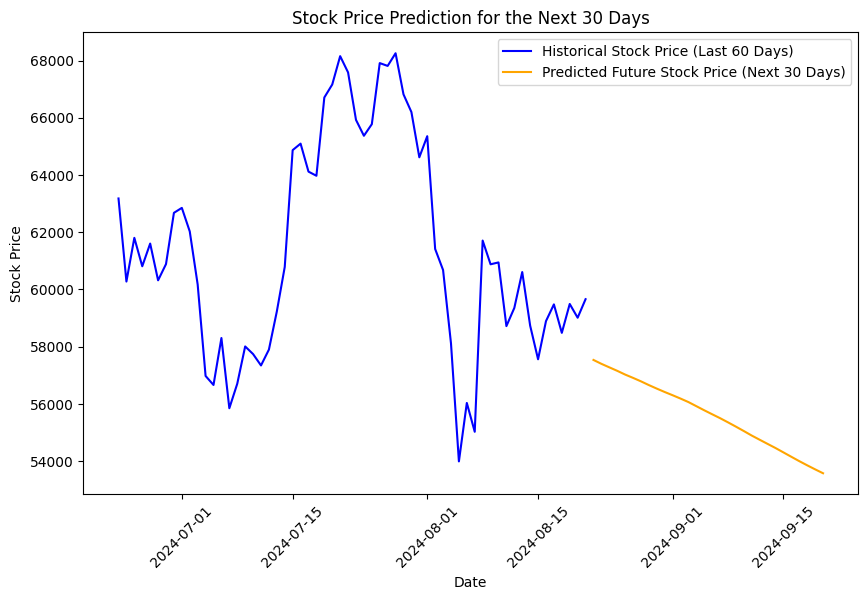

In [16]:
# 함수 사용 예시
recent_60_days_data = df['bit_Close_Scaled'].values[-60:]      # 최근 60일간의 데이터 추출
past_60_days = df['sc_coin'].values[-60:]                      # 원래 스케일의 최근 60일 데이터
past_60_dates = df['sc_date'].values[-60:]                     # 최근 60일간의 날짜 데이터

# 미래 30일 동안의 주가 예측
predictions_scaled_back, future_dates = predict_future_prices(best_model, recent_60_days_data, scaler)

# 예측 결과 시각화
plot_predictions(past_60_days, past_60_dates, predictions_scaled_back, future_dates)

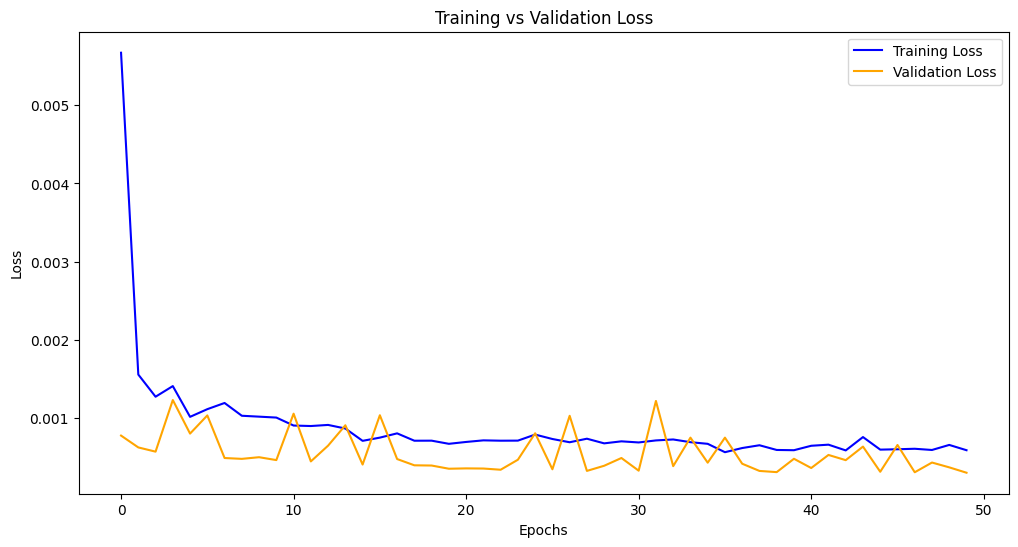

In [19]:
# X축 데이터 날짜 변환
def configure_date_format(ax, date_range):
    date_format = mdates.DateFormatter('%Y-%m')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlim(date_range[0], date_range[-1])
    plt.xticks(rotation=45)

# 1. 학습 손실 및 검증 손실 그래프
def plot_training_history(history):

    # HTML 설명
    html_content = '''
    <div style="border: 2px solid #4CAF50; padding: 15px; border-radius: 10px; background-color: #f9f9f9;">
        <h2 style="color:#4CAF50; font-family: Arial, sans-serif;">🔍 학습 손실 vs 검증 손실 그래프 분석</h2>
        <p style="font-size: 14px; font-family: Arial, sans-serif;">
            이 그래프는 모델의 학습 손실 <span style="color:blue;"><strong>(파란색)</strong></span>과 검증 손실 <span style="color:orange;"><strong>(주황색)</strong></span>을 비교하여, 모델의 성능을 평가하는 데 사용됩니다.
        </p>
        <ul style="font-size: 14px; font-family: Arial, sans-serif;">
            <li><strong>초기 손실:</strong> 학습 초기 단계에서 손실이 급격히 감소하여 모델이 빠르게 패턴을 학습하고 있음을 보여줍니다.</li>
            <li><strong>손실 안정화:</strong> 에포크가 진행됨에 따라 손실 값이 안정화되며, 이는 모델이 수렴되었음을 나타냅니다.</li>
            <li><strong>과적합 여부:</strong> 학습 손실과 검증 손실의 차이가 거의 없으므로, 모델이 과적합되지 않고 잘 일반화되고 있음을 확인할 수 있습니다.</li>
        </ul>
    </div>
    '''
    # HTML 렌더링
    display(HTML_display(html_content))

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 손실 및 검증 손실 그래프 호출
plot_training_history(history)

In [ ]:
predictions_scaled_back

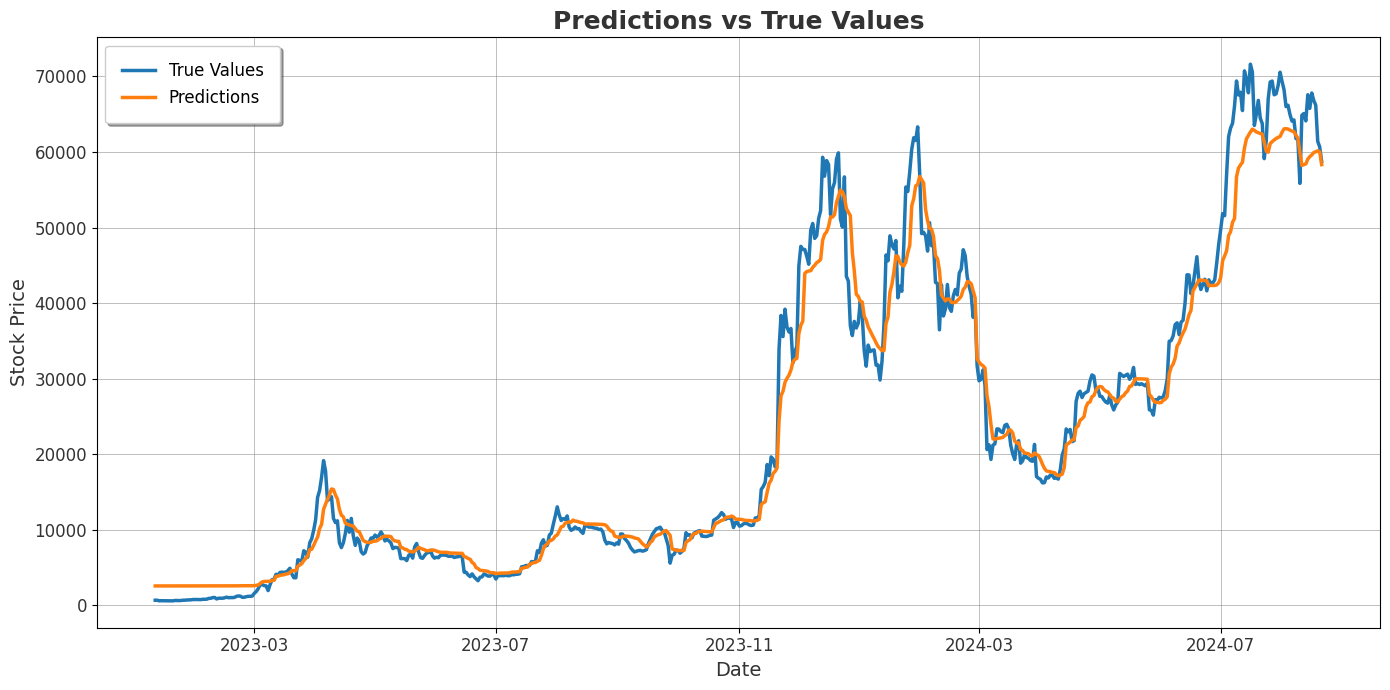

In [32]:
# 1. 예측 값 vs 실제 값 그래프
def plot_predictions(y_test_actual, y_pred, y_test_dates):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_dates, y_test_actual, label='True Values', color='#1f77b4', linewidth=2.5)
    plt.plot(y_test_dates, y_pred, label='Predictions', color='#ff7f0e', linewidth=2.5)
    plt.title('Predictions vs True Values', fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Date', fontsize=14, color='#333333')
    plt.ylabel('Stock Price', fontsize=14, color='#333333')
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, borderpad=1)

    # 날짜 포맷 설정
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.xticks(rotation=0, fontsize=12, color='#333333')
    plt.yticks(fontsize=12, color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 예측 값 vs 실제 값 그래프 호출
plot_predictions(y_test_scaled, y_pred, y_test_dates)

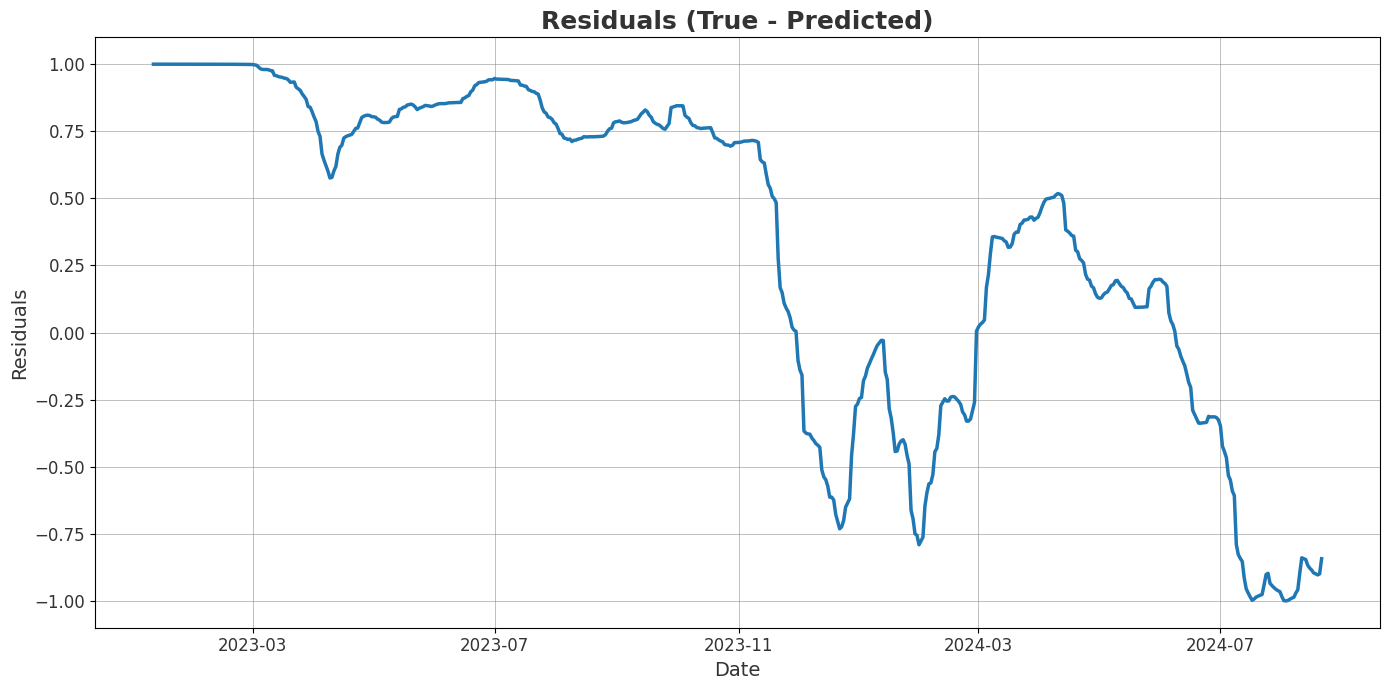

In [39]:
# 3. 잔차 그래프
# 잔차 계산
residuals = y_test.flatten() - y_pred.flatten()

# MinMaxScaler 적용
scaler = MinMaxScaler(feature_range=(-1, 1))  # -1에서 1 사이로 스케일링
residuals_scaled = scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

# 그래프 생성 함수
def plot_residuals(residuals_scaled, y_test_dates):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_dates, residuals_scaled, label='Residuals (True - Predicted)', color='#1f77b4', linewidth=2.5)
    plt.title('Residuals (True - Predicted)', fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Date', fontsize=14, color='#333333')
    plt.ylabel('Residuals', fontsize=14, color='#333333')

    # 날짜 포맷 설정
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.xticks(rotation=0, fontsize=12, color='#333333')
    plt.yticks(fontsize=12, color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 수정된 잔차 그래프 호출
plot_residuals(residuals_scaled, y_test_dates)

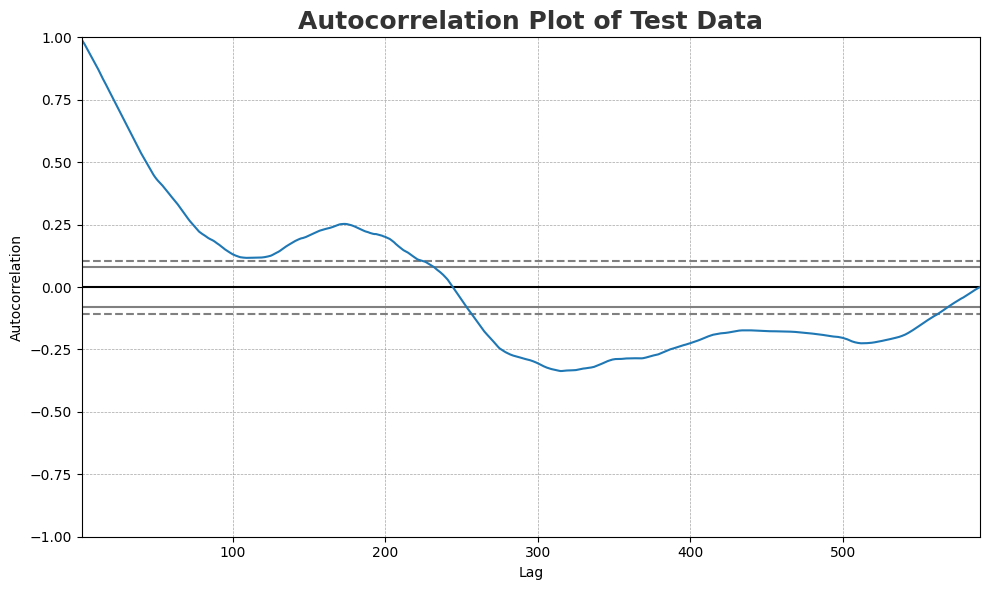

In [45]:
# 4. 자기상관도 그래프
def plot_autocorrelation(y_test, adjusted_dates=None, html_text=None):

    # HTML 설명 블록 설정
    if html_text is None:
        html_text = '''
        <div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9;">
            <h2 style="color:#333333; font-family: 'Arial', sans-serif; text-align:center;">
                🔄 자기상관도 그래프 분석
            </h2>
            <p style="font-size: 15px; font-family: 'Arial', sans-serif; color: #555555; line-height: 1.6;">
                이 그래프는 <strong>시계열 데이터</strong>에서 특정 시차(Lag)를 두고 데이터 간의 <strong>유사성</strong>을 시각적으로 보여줍니다.
                <br><br>
                <strong style="color: #4CAF50;">💡 높은 자기상관:</strong> 그래프에서 초기의 자기상관 값이 높게 나타나면, 데이터가 일정 기간 동안 유사한 패턴을 유지하고 있음을 의미합니다.
                <br>
                <strong style="color: #4CAF50;">🔄 주기적 패턴:</strong> 만약 자기상관이 주기적으로 반복된다면, 데이터에 주기적 패턴이 존재할 가능성을 시사합니다. 이는 모델이 이러한 패턴을 학습하여 예측 성능을 향상시키는 데 도움이 될 수 있습니다.
                <br>
                <strong style="color: #FF5733;">❗ 낮은 자기상관:</strong> 반대로, 자기상관 값이 급격히 감소하거나 일정한 패턴 없이 변동한다면, 이는 데이터가 무작위적이거나 주기적이지 않다는 것을 나타낼 수 있습니다.
                <br><br>
                <strong>X축:</strong> 시차(Lag)로, 시계열 데이터에서 과거 데이터와 현재 데이터 사이의 시간 간격을 나타냅니다.
                <br>
                <strong>Y축:</strong> 자기상관 값으로, 특정 시차에서 데이터의 유사성을 나타내는 값입니다. 1에 가까울수록 강한 양의 상관관계, -1에 가까울수록 강한 음의 상관관계를 의미합니다.
            </p>
        </div>
        '''
    display(HTML_display(html_text))

    plt.figure(figsize=(10, 6))

    # y_test가 시계열인지 확인하고 설정
    if adjusted_dates is not None:
        y_test = pd.Series(y_test, index=adjusted_dates)

    autocorrelation_plot(y_test)
    plt.title('Autocorrelation Plot of Test Data', fontsize=18, fontweight='bold', color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 자기상관도 그래프 호출
plot_autocorrelation(y_test, adjusted_dates=adjusted_dates)

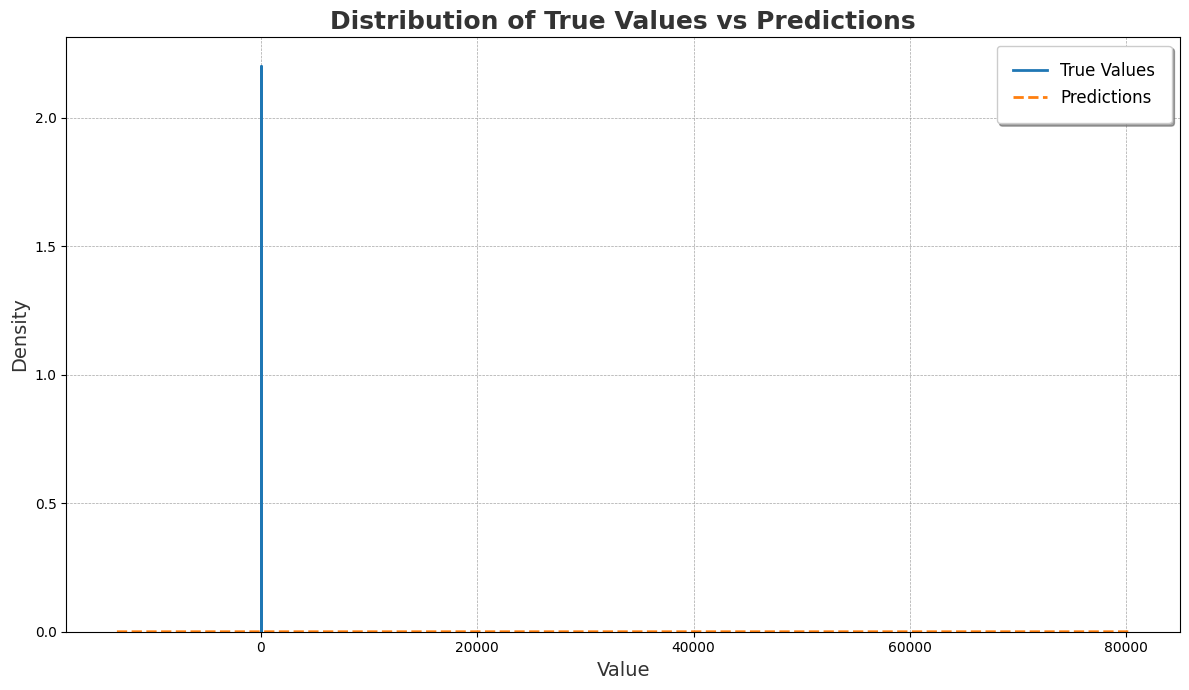

In [49]:
# 5. 커널 밀도 추정 그래프
def plot_distribution_comparison(y_test, y_pred, html_text=None):
    # HTML 설명 블록 설정
    if html_text is None:
        html_text = '''
        <div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9;">
            <h2 style="color:#333333; font-family: 'Arial', sans-serif; text-align:center;">
                📈 커널 밀도 추정 그래프 분석
            </h2>
            <p style="font-size: 15px; font-family: 'Arial', sans-serif; color: #555555; line-height: 1.6;">
                이 그래프는 <strong>실제 값</strong>과 <strong>모델 예측 값</strong>의 분포를 비교하여
                모델이 데이터의 분포를 얼마나 잘 학습했는지 평가합니다.
                <br><br>
                <strong style="color: #4CAF50;">✅ 모델 예측이 잘 맞을 때:</strong> 두 곡선이 서로 잘 겹칩니다. 이는 모델이 실제 데이터의 분포를 잘 학습했음을 의미합니다.
                <br>
                <strong style="color: #FF5733;">❗ 모델 예측이 부정확할 때:</strong> 곡선이 서로 겹치지 않거나 큰 차이가 날 경우, 모델이 데이터의 분포를 제대로 학습하지 못했음을 나타냅니다.
                <br><br>
                <strong>X축:</strong> 변수의 값(Value)을 나타냅니다.
                <br>
                <strong>Y축:</strong> 해당 값이 나타날 확률 밀도(Density)를 나타냅니다.
            </p>
        </div>
        '''
    display(HTML_display(html_text))

    plt.figure(figsize=(12, 7))

    # KDE 플롯: 시계열 데이터가 아닌 순수한 값으로 플롯을 생성
    sns.kdeplot(y_test, label='True Values', color='#1f77b4', linewidth=2)
    sns.kdeplot(y_pred, label='Predictions', color='#ff7f0e', linestyle='--', linewidth=2)

    plt.title('Distribution of True Values vs Predictions', fontsize=18, fontweight='bold', color='#333333')
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True, borderpad=1)
    plt.xlabel('Value', fontsize=14, color='#333333')
    plt.ylabel('Density', fontsize=14, color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 데이터 스케일링 (0과 1 사이로 조정)
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.reshape(-1, 1)).flatten()
y_pred_scaled = scaler.transform(y_pred.reshape(-1, 1)).flatten()

# 커널 밀도 추정 그래프 호출
plot_distribution_comparison(y_test_scaled, y_pred_scaled)

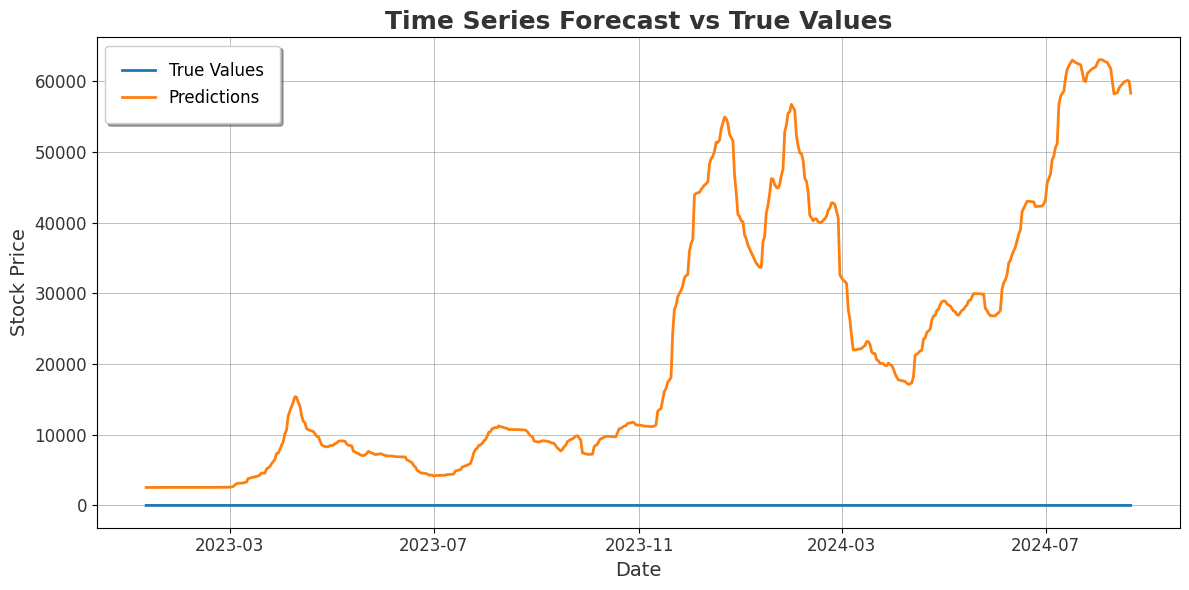

In [53]:
# 6. 시계열 예측 그래프 (Time Series Forecasting Plot)
def plot_time_series_forecast(y_test, y_pred, HTML=None):

    # HTML 설명 블록 설정
    if HTML is None:
        HTML = '''
        <div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9;">
            <h2 style="color:#333333; font-family: 'Arial', sans-serif; text-align:center;">
                ⏳ 시계열 예측 그래프 분석
            </h2>
            <p style="font-size: 15px; font-family: 'Arial', sans-serif; color: #555555; line-height: 1.6;">
                이 그래프는 <strong>시간 축</strong>을 따라 <strong>모델의 예측 값</strong>과 <strong>실제 값</strong>을 비교하여
                시계열 데이터에 대한 모델의 성능을 평가하는 데 사용됩니다.
                <br><br>
                <strong style="color: #4CAF50;">✅ 모델 예측이 정확할 때:</strong> 예측 값과 실제 값이 잘 일치하여, 두 그래프가 서로 겹칩니다.
                <br>
                <strong style="color: #FF5733;">❗ 모델 예측이 부정확할 때:</strong> 예측 값과 실제 값 사이에 큰 차이가 있으며, 이는 모델이 시계열 데이터의 변동성을 잘 학습하지 못했음을 나타냅니다.
                <br><br>
                <strong>X축:</strong> 시간 축(Date)으로, 시계열 데이터의 특정 시점을 나타냅니다.
                <br>
                <strong>Y축:</strong> 주가(Stock Price)로, 해당 시점에서의 주가 값을 나타냅니다.
            </p>
        </div>
        '''
    display(HTML_display(HTML))

    plt.figure(figsize=(12, 6))

    # 시계열 그래프 생성
    plt.plot(y_test.index, y_test, label='True Values', color='#1f77b4', linewidth=2)
    plt.plot(y_pred.index, y_pred, label='Predictions', color='#ff7f0e', linewidth=2)

    plt.title('Time Series Forecast vs True Values', fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Date', fontsize=14, color='#333333')
    plt.ylabel('Stock Price', fontsize=14, color='#333333')

    # 날짜 포맷 설정
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.xticks(rotation=0, fontsize=12, color='#333333')
    plt.yticks(fontsize=12, color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linewidth=0.5, color='gray', alpha=0.7)
    plt.legend(fontsize=12, loc='upper left', frameon=True, shadow=True, borderpad=1)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 시계열 예측 그래프 호출
adjusted_dates = dates[-len(y_test):]
plot_time_series_forecast(pd.Series(y_test, index=adjusted_dates), pd.Series(y_pred.flatten(), index=adjusted_dates))

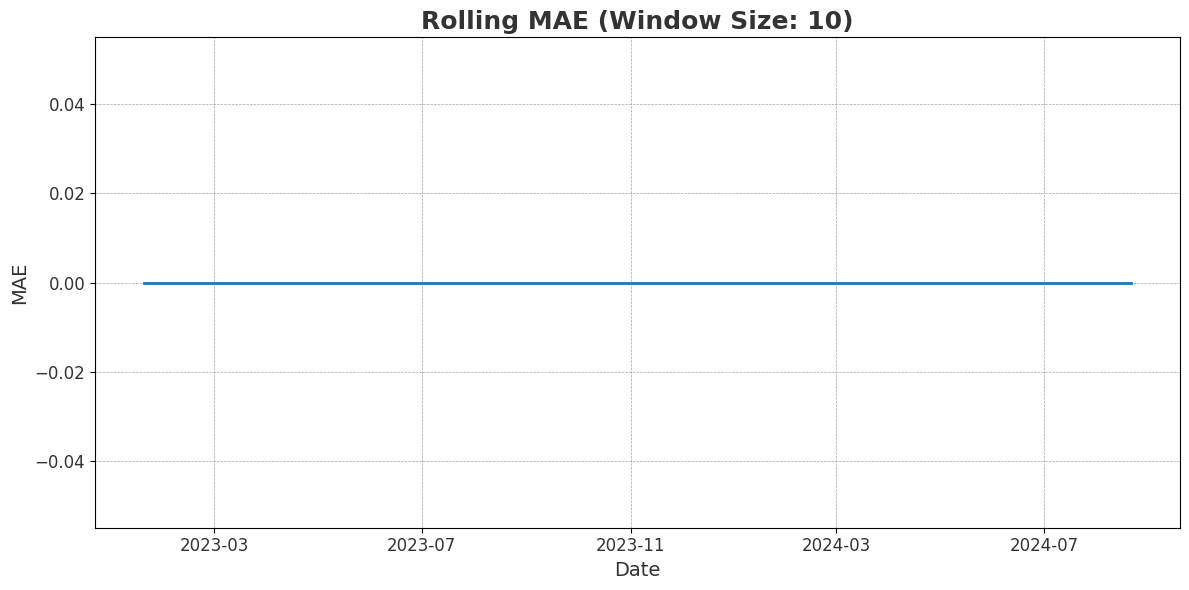

In [58]:
# 7. 평균 절대 오차 (MAE) vs. 시점 그래프
def plot_mae_over_time(y_test, y_pred, window=10, HTML=None):

    # HTML 설명 블록 설정
    if HTML is None:
        HTML = '''
        <div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9;">
            <h2 style="color:#333333; font-family: 'Arial', sans-serif; text-align:center;">
                📉 평균 절대 오차 (MAE) vs. 시점 그래프 분석
            </h2>
            <p style="font-size: 15px; font-family: 'Arial', sans-serif; color: #555555; line-height: 1.6;">
                이 그래프는 <strong>시간에 따른 모델의 예측 성능</strong>을 평가하기 위해,
                <strong>평균 절대 오차(MAE)</strong>를 시각적으로 보여줍니다.
                <br><br>
                <strong style="color: #4CAF50;">✅ 낮은 MAE:</strong> 그래프가 낮고 안정적인 값을 유지할 때, 모델의 예측이 일관되고 정확함을 의미합니다.
                <br>
                <strong style="color: #FF5733;">❗ 높은 MAE:</strong> 그래프에서 MAE가 높아질 때, 이는 모델의 예측 성능이 떨어지거나 변동성이 클 수 있음을 시사합니다.
                <br><br>
                <strong>X축:</strong> 시간 축(Date)으로, 시계열 데이터의 특정 시점을 나타냅니다.
                <br>
                <strong>Y축:</strong> 평균 절대 오차(MAE)로, 예측 값과 실제 값 사이의 차이의 절대값을 평균한 값입니다.
            </p>
        </div>
        '''
    display(HTML_display(HTML))

    # MAE 계산
    mae = np.abs(y_test - y_pred)
    rolling_mae = mae.rolling(window=window).mean()

    # 그래프 생성
    plt.figure(figsize=(12, 6))
    plt.plot(rolling_mae.index, rolling_mae, color='#1f77b4', linewidth=2)
    plt.title(f'Rolling MAE (Window Size: {window})', fontsize=18, fontweight='bold', color='#333333')
    plt.xlabel('Date', fontsize=14, color='#333333')
    plt.ylabel('MAE', fontsize=14, color='#333333')

    # 날짜 포맷 설정
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.xticks(rotation=0, fontsize=12, color='#333333')
    plt.yticks(fontsize=12, color='#333333')

    # 그래프 스타일 추가
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.tight_layout()

    # 그래프 표시
    plt.show()
y_test_pred = y_test
# 평균 절대 오차(MAE) vs 시점 그래프 호출
plot_mae_over_time(pd.Series(y_test, index=adjusted_dates), pd.Series(y_test_pred.flatten(), index=adjusted_dates))

In [62]:
# 8. 피어슨 상관계수 히트맵 (Correlation Heatmap)
df[f'{find_word}_shifted'] = df[find_word].shift(1).fillna(0)

# 피어슨 상관계수 히트맵 함수 정의
def plot_correlation_heatmap(dataframe, html_text=None):
    # HTML 설명 블록 설정
    if html_text is None:
        html_text = '''
        <div style="border: 2px solid #4CAF50; padding: 20px; border-radius: 10px; background-color: #f9f9f9;">
            <h2 style="color:#333333; font-family: 'Arial', sans-serif; text-align:center;">
                🔍 피어슨 상관계수 히트맵 분석
            </h2>
            <p style="font-size: 15px; font-family: 'Arial', sans-serif; color: #555555; line-height: 1.6;">
                이 히트맵은 데이터 프레임에 포함된 여러 변수들 간의 <strong>상관관계</strong>를 시각적으로 보여줍니다.
                <br><br>
                <strong style="color: #4CAF50;">✅ 높은 상관관계:</strong> 두 변수 간의 상관계수 값이 1 또는 -1에 가까울수록, 그 변수들이 서로 강하게 양(또는 음)의 상관관계를 가짐을 나타냅니다.
                <br>
                <strong style="color: #FF5733;">❗ 낮은 상관관계:</strong> 상관계수 값이 0에 가까울수록, 두 변수 간의 관계가 약하거나 무작위적일 가능성이 높습니다.
                <br><br>
                <strong>히트맵 이해:</strong>
                <ul style="font-size: 14px; line-height: 1.6;">
                    <li><strong>X축과 Y축:</strong> 비교하는 두 변수의 이름을 나타냅니다.</li>
                    <li><strong>색상:</strong> 상관계수 값의 크기에 따라 색상이 변합니다. 빨간색에 가까울수록 양의 상관관계가 크고, 파란색에 가까울수록 음의 상관관계가 큽니다.</li>
                    <li><strong>숫자:</strong> 각 셀에 표시된 숫자는 변수 간의 상관계수 값을 나타냅니다.</li>
                </ul>
            </p>
        </div>
        '''
    display(HTML_display(html_text))

    plt.figure(figsize=(10, 8))

    # 상관계수 행렬 계산
    correlation_matrix = dataframe.corr()

    # 히트맵 생성
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={"shrink": 0.75})
    plt.title('Correlation Heatmap', fontsize=18, fontweight='bold', color='#333333')

    # 그래프 스타일 추가
    plt.xticks(rotation=0, fontsize=12, color='#333333')
    plt.yticks(rotation=90, fontsize=12, color='#333333')
    plt.tight_layout()

    # 그래프 표시
    plt.show()

# 수치형 열만 선택하여 피어슨 상관계수 히트맵 호출
plot_correlation_heatmap(df[[find_word, f'{df}_shifted']])

NameError: name 'stock_df' is not defined

In [22]:
# 최적의 하이퍼파라미터를 사용해 모델을 다시 학습
print(f'\nBest model found at fold {best_fold} with loss {best_loss}')
print(f'Best hyperparameters: {best_hyperparameters.values}')

# 최적의 모델을 다시 저장
final_model_save_path = "../saved_models/regression_bitcoin_gru.h5"
best_model.save(final_model_save_path)
print(f'Final best model saved at {final_model_save_path}')


Best model found at fold 3 with loss 0.005109727848321199
Best hyperparameters: {'units': 320, 'dropout_rate': 0.2, 'learning_rate': 0.0002685272714053744}
Final best model saved at ../saved_models/regression_bitcoin_gru.h5
